In [52]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime, timezone
from scipy.interpolate import interp1d
from functools import lru_cache

In [2]:
DATA_DIR = (Path.cwd() / ".." / "Data").resolve()

In [45]:
assert (DATA_DIR / "CH 2020-2021.csv").exists()
assert (DATA_DIR / "metervalues_pseudonymized_1_neu.csv").exists()
assert (DATA_DIR / "metervalues_pseudonymized_2_neu.csv").exists()

In [54]:
meter_1 = pd.read_csv(DATA_DIR / "metervalues_pseudonymized_1_neu.csv", delimiter=";")
# Clean extra row of headers
meter_1 = meter_1[meter_1["id"] != "id"]

/Users/cmutel/miniconda3/envs/bw2dev38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (0,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [55]:
meter_1["id"] = pd.to_numeric(meter_1["id"])
meter_1["timestamp"] = pd.to_datetime(meter_1["timestamp"])
meter_1["Chargepoint"] = meter_1["Chargepoint"].apply(int)
meter_1["metervalue"] = pd.to_numeric(meter_1["metervalue"])
meter_1["increment"] = pd.to_numeric(meter_1["increment"])

In [56]:
meter_2 = pd.read_csv(DATA_DIR / "metervalues_pseudonymized_2_neu.csv", 
                      delimiter=";", 
                      header=0)

/Users/cmutel/miniconda3/envs/bw2dev38/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [57]:
meter_2["id"] = pd.to_numeric(meter_2["id"])
meter_2["timestamp"] = pd.to_datetime(meter_2["timestamp"])
mask = meter_2["Chargepoint"].isnull()
meter_2["Chargepoint"][mask] = 42
meter_2["Chargepoint"] = meter_2["Chargepoint"].apply(int)
meter_2["metervalue"] = pd.to_numeric(meter_2["metervalue"])
meter_2["increment"] = pd.to_numeric(meter_2["increment"])

<ipython-input-57-3612a84dc8b8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meter_2["Chargepoint"][mask] = 42


In [58]:
meter = pd.concat([meter_1, meter_2])

In [59]:
meter_1 = meter_2 = None

In [60]:
co2 = pd.read_csv(DATA_DIR / "CH 2020-2021.csv")

In [61]:
UNNECESSARY = [
 'created_at',
 'updated_at',
 'timestamp',
 'zone_name',
 'carbon_intensity_discharge_avg',
 'carbon_origin_percent_nuclear_avg',
 'carbon_origin_percent_geothermal_avg',
 'carbon_origin_percent_biomass_avg',
 'carbon_origin_percent_coal_avg',
 'carbon_origin_percent_wind_avg',
 'carbon_origin_percent_solar_avg',
 'carbon_origin_percent_hydro_avg',
 'carbon_origin_percent_gas_avg',
 'carbon_origin_percent_oil_avg',
 'carbon_origin_percent_unknown_avg',
 'carbon_origin_percent_battery_discharge_avg',
 'carbon_origin_percent_hydro_discharge_avg',
 'power_net_discharge_battery_avg',
 'power_net_discharge_hydro_avg',
 'power_net_import_AT_avg',
 'carbon_intensity_exchange_AT_avg',
 'power_net_import_DE_avg',
 'carbon_intensity_exchange_DE_avg',
 'power_net_import_FR_avg',
 'carbon_intensity_exchange_FR_avg',
 'power_net_import_IT-NO_avg',
 'carbon_intensity_exchange_IT-NO_avg',
 'latest_forecasted_wind_x_avg',
 'latest_forecasted_wind_y_avg',
 'latest_forecasted_solar_avg',
 'latest_forecasted_temperature_avg',
 'latest_forecasted_dewpoint_avg',
 'latest_forecasted_precipitation_avg',
 'latest_forecasted_price_avg',
 'latest_forecasted_production_avg',
 'latest_forecasted_consumption_avg',
 'latest_forecasted_power_net_import_AT_avg',
 'latest_forecasted_power_net_import_DE_avg',
 'latest_forecasted_power_net_import_FR_avg',
 'latest_forecasted_power_net_import_IT-NO_avg',
 'latest_forecasted_production_solar_avg',
 'latest_forecasted_production_wind_avg',
 'power_origin_percent_fossil_avg',
 'power_origin_percent_renewable_avg',
 'power_production_percent_fossil_avg',
 'power_production_percent_renewable_avg',
 'power_production_nuclear_avg',
 'power_production_geothermal_avg',
 'power_production_biomass_avg',
 'power_production_coal_avg',
 'power_production_wind_avg',
 'power_production_solar_avg',
 'power_production_hydro_avg',
 'power_production_gas_avg',
 'power_production_oil_avg',
 'power_production_unknown_avg',
 'total_consumption_avg',
 'carbon_rate_avg',
 'total_production_avg',
 'total_storage_avg',
 'total_discharge_avg',
 'total_import_avg',
 'total_export_avg',
 'production_sources'
]

In [62]:
co2.drop(UNNECESSARY, axis=1, inplace=True)

In [63]:
co2["datetime"] = pd.to_datetime(co2["datetime"])

In [64]:
mapping = {
    'carbon_intensity_avg': 'co2_intensity',  # g / kWh
    'carbon_intensity_production_avg': 'co2_production',
    'carbon_intensity_import_avg': 'co2_import',
    'power_consumption_nuclear_avg': 'nuclear',
    'power_consumption_geothermal_avg': 'geothermal',
    'power_consumption_biomass_avg': 'biomass',
    'power_consumption_coal_avg': 'coal',
    'power_consumption_wind_avg': 'wind',
    'power_consumption_solar_avg': 'solar',
    'power_consumption_hydro_avg': 'hydro',
    'power_consumption_gas_avg': 'gas',
    'power_consumption_oil_avg': 'oil',
    'power_consumption_unknown_avg': 'unknown',
    'power_consumption_battery_discharge_avg': 'battery',
    'power_consumption_hydro_discharge_avg': 'hydro',
}

co2.rename(mapping, axis=1, inplace=True)

In [65]:
co2.dtypes

datetime          datetime64[ns, UTC]
co2_intensity                 float64
co2_production                float64
co2_import                    float64
nuclear                       float64
geothermal                    float64
biomass                       float64
coal                          float64
wind                          float64
solar                         float64
hydro                         float64
gas                           float64
oil                           float64
unknown                       float64
battery                       float64
hydro                         float64
dtype: object

In [66]:
co2

,datetime,co2_intensity,co2_production,co2_import,nuclear,geothermal,biomass,coal,wind,solar,hydro,gas,oil,unknown,battery,hydro
0,2020-01-01 00:00:00+00:00,115.53,42.25,239.46,3321.21,0.14,235.03,442.94,445.71,0.00,1034.33,293.46,18.54,1038.76,0.0,181.97
1,2020-01-01 01:00:00+00:00,113.57,46.79,255.94,3224.89,0.14,224.68,432.04,437.79,0.00,1046.74,245.34,17.31,1323.84,0.0,181.31
2,2020-01-01 02:00:00+00:00,113.70,30.13,235.80,3671.14,3.17,252.13,471.63,472.28,0.01,1107.86,306.60,20.47,586.79,0.0,81.00
3,2020-01-01 03:00:00+00:00,110.52,48.75,231.63,3638.54,9.61,206.78,376.36,365.74,0.02,1036.09,323.40,17.47,1510.04,0.0,97.00
4,2020-01-01 04:00:00+00:00,111.10,41.83,240.52,3571.64,5.70,222.40,411.97,397.42,0.02,1041.85,290.49,18.23,1123.35,0.0,97.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,2021-06-30 19:00:00+00:00,74.55,71.97,NaN,918.46,0.00,0.00,0.00,0.00,0.00,1812.00,0.00,0.00,2405.48,0.0,1064.06
13124,2021-06-30 20:00:00+00:00,78.65,77.04,NaN,943.88,0.00,0.00,0.00,0.00,0.00,1715.01,0.00,0.00,2823.69,0.0,1052.42
13125,2021-06-30 21:00:00+00:00,103.10,71.17,348.64,1061.13,0.22,52.81,184.39,128.09,0.00,1456.45,83.60,4.48,2066.78,0.0,692.06
13126,2021-06-30 22:00:00+00:00,120.71,82.12,342.61,1215.24,0.34,76.70,251.02,193.26,0.01,967.38,95.31,6.64,2635.87,0.0,198.25


In [79]:
epoch = pd.to_datetime(0, utc=True)
neutral_epoch = pd.to_datetime(0)

def to_unix_timestamp(x):
    return (x - epoch).total_seconds()

def to_unix_timestamp_neutral(x):
    return (x - neutral_epoch).total_seconds()

In [101]:
interp_dict = {}

for x in range(int(len(co2) / 24)):
    if x == 0:
        start, end = x * 24, (x + 1) * 24 + 6
    elif x == 546:
        start, end = x * 24 - 6, (x + 1) * 24
    else:
        start, end = x * 24 - 6, (x + 1) * 24 + 6
    xs = co2['datetime'][start:end].apply(to_unix_timestamp)
    ys = co2['co2_intensity'][start:end]
    dt = co2['datetime'][x * 24]
    interp_dict[(dt.year, dt.month, dt.day)] = interp1d(xs, ys, kind='cubic')

In [118]:
def get_co2_for_datetime(dt):
    try:
        func = interp_dict[(dt.year, dt.month, dt.day)]
        return float(func(to_unix_timestamp_neutral(dt)))
    except (KeyError, ValueError):
        return 0

In [119]:
meter['co2_intensity'] = meter['timestamp'].apply(get_co2_for_datetime)

In [120]:
meter['co2_total'] = meter['co2_intensity'] * meter['increment'] / 1000

Check to see how many values are missing

In [122]:
(meter['co2_intensity'] == 0).sum(), (meter['co2_intensity'] != 0).sum()

(209005, 966100)

Is this due to dates past our last CO2 data, or some other error?

In [123]:
co2['datetime'].max()

Timestamp('2021-06-30 23:00:00+0000', tz='UTC')

In [127]:
meter['timestamp'][0]

0   2021-01-01 00:15:00
0   2020-01-07 00:15:00
Name: timestamp, dtype: datetime64[ns]

In [128]:
(meter['timestamp'] > np.datetime64('2021-06-30 23:00:00+0000')).sum()

<ipython-input-128-733fe0b6ca5f>:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  (meter['timestamp'] > np.datetime64('2021-06-30 23:00:00+0000')).sum()


209005

OK, this is reasonable. We just don't have the data for later dates.

Visualize some patterns:

In [11]:
%matplotlib inline

In [39]:
from matplotlib import pyplot as plt

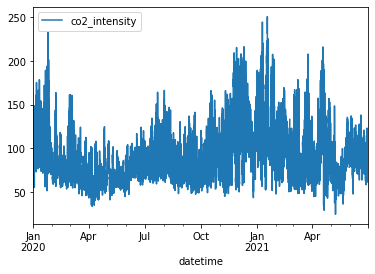

In [43]:
co2.plot(x='datetime', y='co2_intensity')

In [36]:
epoch = pd.to_datetime(0, utc=True)

In [37]:
xs = co2[1000:1050]['datetime'].apply(lambda x: (x - epoch).total_seconds())
ys = co2[1000:1050]['co2_intensity']

In [40]:
interp_func = interp1d(xs, ys, kind='cubic')

In [41]:
new_xs = np.linspace(xs.min(), xs.max(), 200)

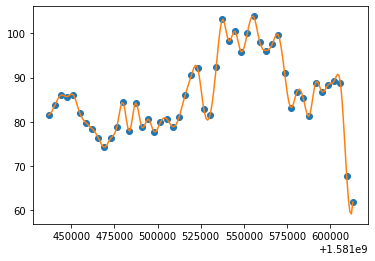

In [42]:
plt.plot(xs, ys, 'o', new_xs, interp_func(new_xs), '-')